In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import glob
from datetime import datetime

In [2]:
PRAW_OUTPUT_DIR = 'praw_output'
POSTS_DIR = 'posts'
COMMENTS_DIR = 'post_comments'

In [3]:
all_post_tsvs = glob.glob(os.path.join(PRAW_OUTPUT_DIR,POSTS_DIR,'*.tsv'))
all_post_comment_tsvs = glob.glob(os.path.join(PRAW_OUTPUT_DIR,COMMENTS_DIR,'*.tsv'))
len(all_post_tsvs),len(all_post_comment_tsvs)

(68, 58)

In [4]:
# Join separate tsvs under single df
post_dfs = [pd.read_csv(f,sep='\t',header=0) for f in all_post_tsvs]
all_posts_df = pd.concat(post_dfs,axis=0)
comment_dfs = [pd.read_csv(f,sep='\t',header=0) for f in all_post_comment_tsvs]
all_comments_df = pd.concat(comment_dfs,axis=0)
all_posts_df.shape,all_comments_df.shape

((32301, 12), (371, 11))

In [5]:
# Add column for parsed date
all_posts_df['parsed_date'] = all_posts_df.date.apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isnull(x)
                                                     else None)
all_comments_df['parsed_date'] = all_comments_df.date.apply(lambda x: datetime.utcfromtimestamp(x) if not 
                                                           pd.isnull(x) else None)

In [6]:
# Extract month, year
all_posts_df['year'] = all_posts_df.parsed_date.apply(lambda x: x.year if not pd.isnull(x)
                                                     else None)
all_comments_df['year'] = all_comments_df.parsed_date.apply(lambda x: x.year if not 
                                                           pd.isnull(x) else None)
all_posts_df['month'] = all_posts_df.parsed_date.apply(lambda x: x.month if not pd.isnull(x)
                                                     else None)
all_comments_df['month'] = all_comments_df.parsed_date.apply(lambda x: x.month if not 
                                                           pd.isnull(x) else None)

In [7]:
all_posts_df.head()

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
0,"Not Hard , we need a beautiful world and democ...",bappa158,1.594488e+09,False,hp71sk,0.0,1.0,1.0,0.0,1.0,NaN,350,2020-07-11 17:11:59,2020.0,7.0
1,"Youth , democracy and new social orders. With ...",bappa158,1.594249e+09,False,hnike7,0.0,1.0,1.0,0.0,1.0,NaN,350,2020-07-08 23:00:03,2020.0,7.0
2,A tale of two Democracies. Narrative is in eng...,bappa158,1.593279e+09,False,hgqidf,0.0,1.0,0.6,0.0,1.0,NaN,350,2020-06-27 17:25:24,2020.0,6.0
3,Do you want to use your time and skills to res...,SavedWhale,1.593125e+09,False,hfndnl,0.0,3.0,1.0,0.0,3.0,I started a non-profit that connects volunteer...,350,2020-06-25 22:48:56,2020.0,6.0
4,Ture Democracy for all is the best solution,bappa158,1.592689e+09,False,hcmim7,0.0,1.0,1.0,0.0,1.0,NaN,350,2020-06-20 21:44:35,2020.0,6.0


In [29]:
all_comments_df.head()

,submission_id,author,text,date,id,controversiality,num_downs,num_ups,num_likes,score,subreddit,parsed_date,year,month
0,1ojwx3,stricknacco,sounds good!,1.382445e+09,ccwwa76,0.0,0.0,2.0,NaN,2.0,350,2013-10-22 12:26:11,2013.0,10.0
0,sjh3v,gabefair,This is a follow up from http://www.reddit.com...,1.334949e+09,c4eibqo,0.0,0.0,1.0,NaN,1.0,350ppm,2012-04-20 19:13:35,2012.0,4.0
0,gjfj1f,-1,[removed],1.589470e+09,fqkzya6,0.0,0.0,5.0,NaN,5.0,askaconservative,2020-05-14 15:32:10,2020.0,5.0
1,gjfj1f,oispa,> what are your views on a minimum wage?It's a...,1.589461e+09,fqkoiqi,0.0,0.0,5.0,NaN,5.0,askaconservative,2020-05-14 12:54:25,2020.0,5.0
2,gjfj1f,DingbattheGreat,> what are your views on a minimum wage? It sh...,1.589472e+09,fql1gde,0.0,0.0,3.0,NaN,3.0,askaconservative,2020-05-14 15:56:18,2020.0,5.0


## Explore distribution of each attribute 

In [8]:
print('Number of unique subreddits for posts:',len(all_posts_df.subreddit.value_counts()))
print('Number of unique subreddits for comments:',len(all_comments_df.subreddit.value_counts()))

Number of unique subreddits for posts: 63
Number of unique subreddits for comments: 57


In [9]:
print('Number of unique post authors:',len(all_posts_df.author.value_counts()))
print('Number of unique comment authors:',len(all_comments_df.author.value_counts()))
print('Number of unique authors overall:',len(set(all_comments_df.author.value_counts().index) | 
                                             set(all_posts_df.author.value_counts().index)))

Number of unique post authors: 9350
Number of unique comment authors: 219
Number of unique authors overall: 9491


Distribution of posts/comments from different authors: AxesSubplot(0.125,0.125;0.775x0.755)


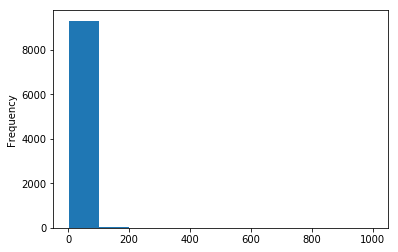

In [11]:
%matplotlib inline
print('Distribution of posts/comments from different authors:',all_posts_df.author.value_counts().plot.hist())

In [18]:
all_posts_df.loc[~all_posts_df.author.isin({-1,str(-1)})].author.value_counts()#.plot.hist(bins=20)

avogadros_number        922
ILikeNeurons            579
heystoopid              532
Foubar                  494
Vailhem                 372
                       ... 
demon-haunted-world_      1
BeautifulLongjumping      1
ProhibitionJones          1
CDninja                   1
polodroid74               1
Name: author, Length: 9348, dtype: int64

Distribution over time of posts: AxesSubplot(0.125,0.125;0.775x0.755)


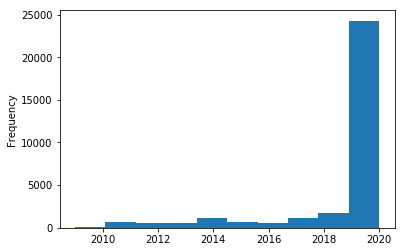

In [19]:
print('Distribution over time of posts:',all_posts_df.year.plot.hist())

Distribution over time of comments: AxesSubplot(0.125,0.125;0.775x0.755)


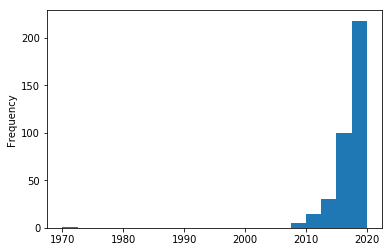

In [20]:
print('Distribution over time of comments:',all_comments_df.year.plot.hist(bins=20))

In [40]:
print('Distribution over controversiality of comments:')
all_comments_df.controversiality.value_counts()

Distribution over controversiality of comments:


0.0    364
1.0      5
Name: controversiality, dtype: int64

In [44]:
# Examine most controversial comments
list(all_comments_df.loc[all_comments_df.controversiality == 1.0].text)

['These have all been covered at the daily briefings.  Have you watched them?    Not sure what else can be done.    As far as the past goes, yes, H1N1 wiped out the supplies, those need refreshed.',
 "And the WHO was telling the world it wasn't contagious at that point. Meanwhile GEOTUS formed the task force and shut down travel from China, for which Dems attacked him.",
 'c0gpcim',
 "If you ask a medical professional how best to prevent the spread of the virus, an economist how best to protect peoples livelihoods, and a mental health professional the best way of protecting people's sanity...you're going to end up with some very conflicting policy.Politicians have to draw it all together and make it work. Spoilers: you can't.",
 "Because global warming has been turned into a focal point of contrarians. The word itself has been tainted, and just because it's cold out doesn't mean that global warming isn't still a huge problem."]

In [49]:
# Small bug in comment ids affecting 3 comments (does not seem consequential for now)
all_comments_df.id.apply(lambda x: type(x)).value_counts()

<class 'str'>      368
<class 'float'>      3
Name: id, dtype: int64

In [50]:
all_comments_df.loc[all_comments_df.id.apply(lambda x: type(x) == float)]

,submission_id,author,text,date,id,controversiality,num_downs,num_ups,num_likes,score,subreddit,parsed_date,year,month
0,ab3wt,heystoopid,|[Total BS](http://www.wunderground.com/blog/J...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,[And crock of the week too !](http://climatepr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,[A word from a supreme authority on this issue...,1259988777.0,c0gpcim,0.0,0,1.0,NaN,1.0,climategate,NaN,NaN,1970-01-01,1970.0,1.0


In [51]:
# But affects a lot more posts--not sure if they're truly NaNs or not
all_posts_df.id.apply(lambda x: type(x)).value_counts()

<class 'str'>      31568
<class 'float'>      733
Name: id, dtype: int64

In [52]:
all_posts_df.loc[all_posts_df.id.apply(lambda x: type(x) == float)]

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
30,|IT’S TIME TO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
31,CONNECT THE DOTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
34,|INSERT ___________ HERE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
470,Started to school strike for climate change ou...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
471,Greta Thunberg started the global movement Fri...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,|Effect of Record Drought on Amazon Studied -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
914,|Peru's arid capital in serious danger of runn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
918,|Scientists study record-breaking 2010 heatwave -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
953,|China's weather forecasters reluctant to conf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


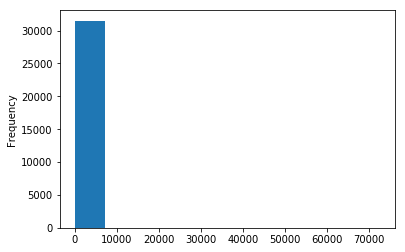

In [57]:
all_posts_df.num_ups.plot.hist(bins=10)

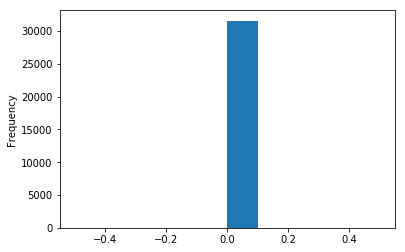

In [58]:
all_posts_df.num_downs.plot.hist(bins=10)

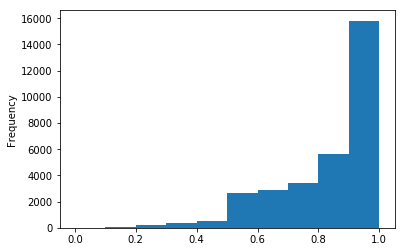

In [60]:
# Better signal that num_ups/num_downs--probably best available signal
all_posts_df.upvote_ratio.plot.hist(bins=10) 

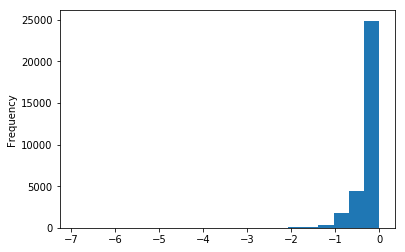

In [24]:
# Log upvote ratio:
all_posts_df.upvote_ratio.apply(lambda x: np.log(x+0.001)).plot.hist(bins=20) 

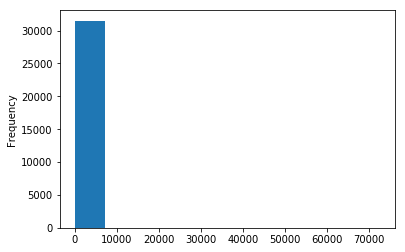

In [61]:
all_posts_df.score.plot.hist(bins=10)

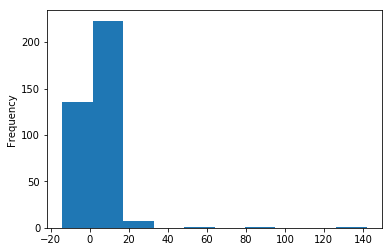

In [56]:
all_comments_df.num_ups.plot.hist(bins=10) # not a great signal

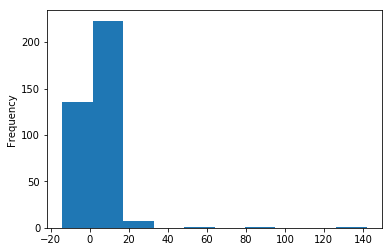

In [62]:
# Score is the same as num_ups
all_comments_df.score.plot.hist(bins=10)

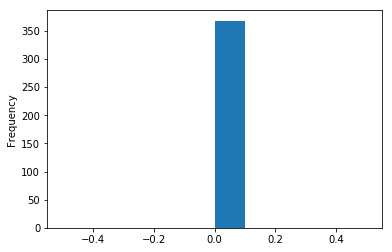

In [59]:
all_comments_df.num_downs.plot.hist(bins=10)

In [64]:
all_comments_df.num_likes#.plot.hist(bins=10)
# Comments don't have upvote ratio available as attribute

0    NaN
0    NaN
0    NaN
1    NaN
2    NaN
    ... 
0    NaN
1    NaN
2    NaN
0    NaN
1    NaN
Name: num_likes, Length: 371, dtype: object

In [82]:
# 63 posts are videos
all_posts_df.is_video.value_counts()

False    31505
True        63
Name: is_video, dtype: int64

## Explore general properties of text

In [67]:
all_comments_df.loc[all_comments_df.text.apply(lambda x: type(x) == float)]

,submission_id,author,text,date,id,controversiality,num_downs,num_ups,num_likes,score,subreddit,parsed_date,year,month
1,[And crock of the week too !](http://climatepr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


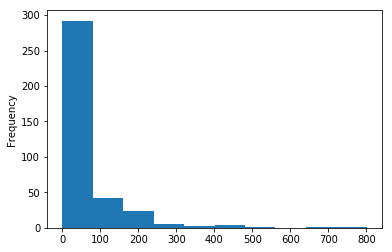

In [71]:
# Length of comments in "words" (split on whitespace)
all_comments_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0).plot.hist()

In [30]:
# Number of posts/comments with <=50 words, per Reid's threshold
all_comments_df['length'] = all_comments_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0)
all_posts_df['text_length'] = all_posts_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0)
all_posts_df['title_length'] = all_posts_df.title.apply(lambda x: len(x.split()) if type(x) != float else 0)
print(all_comments_df.loc[all_comments_df.length.apply(lambda x: x > 0 and x <= 50)].shape,
all_posts_df.loc[all_posts_df.text_length.apply(lambda x: x > 0 and x <= 50)].shape,
     all_posts_df.loc[all_posts_df.title_length.apply(lambda x: x > 0 and x <= 50)].shape)

(261, 15) (2460, 18) (32192, 18)


In [79]:
all_comments_df.text.apply(lambda x: len(x) if type(x) != float else 0).value_counts()

9      16
7       5
58      5
78      4
221     4
       ..
244     1
430     1
192     1
238     1
0       1
Name: text, Length: 263, dtype: int64

In [90]:
# Posts with title content: there are 32.2k (all have titles)
posts_with_titles = all_posts_df.loc[~pd.isnull(all_posts_df.title)]
posts_with_titles.shape

(32301, 15)

In [84]:
# Posts with text content: there are only 6.6k
posts_with_text = all_posts_df.loc[~pd.isnull(all_posts_df.text)]
posts_with_text.shape

(6620, 15)

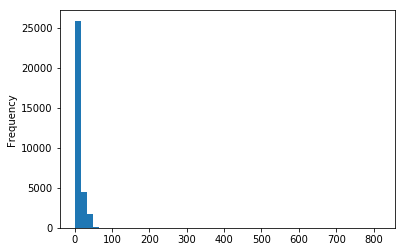

In [91]:
# Length of titles in whitespace-split "words"
posts_with_titles.title.apply(lambda x: len(x.split())).plot.hist(bins=50)

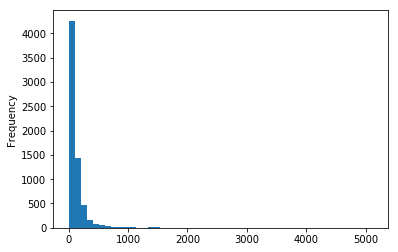

In [86]:
# Length of posts in whitespace-split "words"
posts_with_text.text.apply(lambda x: len(x.split())).plot.hist(bins=50)

In [92]:
# Titles
posts_with_titles.title.apply(lambda x: len(x.split())).value_counts()

9      2565
10     2499
8      2489
11     2386
7      2206
       ... 
73        1
58        1
156       1
61        1
815       1
Name: title, Length: 63, dtype: int64

In [88]:
# A lot of posts have 1 word?
posts_with_text.text.apply(lambda x: len(x.split())).value_counts()

1       144
32       67
38       65
22       63
34       62
       ... 
909       1
945       1
953       1
961       1
1843      1
Name: text, Length: 615, dtype: int64

In [89]:
posts_with_text.loc[posts_with_text.text.apply(lambda x: len(x.split()) == 1)]

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
26,Do you agree with -- and/or can you explain wh...,WentzToDJax,1.594729e+09,False,hqulpf,0.0,2.0,0.63,9.0,2.0,https://www.minnpost.com/eric-black-ink/2013/0...,askaconservative,2020-07-14 12:08:34,2020.0,7.0
161,What do you think about bayonets being issued ...,Lavaknight368,1.593848e+09,False,hktcbx,0.0,3.0,1.00,21.0,3.0,https://thehill.com/policy/defense/505717-mill...,askaconservative,2020-07-04 07:32:46,2020.0,7.0
311,How likely is Trump to win (%)?,renaissance_pancakes,1.592994e+09,False,hesd7h,0.0,5.0,0.70,23.0,5.0,Go.,askaconservative,2020-06-24 10:20:14,2020.0,6.0
507,Are there any good conservative historians who...,ActualStreet,1.592009e+09,False,h7o8lv,0.0,6.0,0.88,3.0,6.0,Thanks,askaconservative,2020-06-13 00:42:35,2020.0,6.0
627,What should happen to Kayleigh McEnany if she ...,fizzywater42,1.591473e+09,False,gxpnui,0.0,17.0,0.80,11.0,17.0,https://www.huffpost.com/entry/trump-maralago-...,askaconservative,2020-06-06 19:56:19,2020.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Alex O'Connor (A.K.A. Cosmic Skeptic) is curre...,Omnibeneviolent,1.594266e+09,False,hnntvy,0.0,10.0,0.72,0.0,10.0,https://www.reddit.com/r/vegan/comments/hnmyk0...,skeptic,2020-07-09 03:36:18,2020.0,7.0
167,I love science guys!,AmazingPineaple6,1.593731e+09,False,hjyncq,0.0,0.0,0.10,0.0,0.0,https://encrypted-tbn0.gstatic.com/images?q=tb...,skeptic,2020-07-02 23:04:38,2020.0,7.0
490,Virus man-made according to Norwegian researcher,oli_gendebien,1.591601e+09,False,gyn7bl,0.0,0.0,0.25,9.0,0.0,https://www.forbes.com/sites/davidnikel/2020/0...,skeptic,2020-06-08 07:23:49,2020.0,6.0
1,A new nature economy could generate up to $10....,clim8pablo,1.594849e+09,False,hrnlof,0.0,11.0,1.00,0.0,11.0,[https://www.weforum.org/reports/new-nature-ec...,sustainability,2020-07-15 21:31:58,2020.0,7.0
